# ISCCP - preprocessing

This notebook extracts the data from the raw ISCCP data files that is relevant for the analysis of the CCIC climate data record. It also visualizes basic properties of these variables.

In [1]:
from pathlib import Path

import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

mpl.style.use("../ccic.mplstyle")

## ISCCP variables

The ISCCP variables for the comparison to CCIC are the cloud amount (CA, variable name: *cldamt*) and the frozen-fraction of cloud water path (WP, variable name *wp*. Unfortunately, ISCCP does not seem to report the ice water path directly but only the mean water path for different cloud types. Since the cloud types have associated phases, it should be possible to estimate the ice water path by summing the contribtutions from frozen cloud types.

> **NOTE**: The ice water path calculated in this way is only available during daytime.


### Calculation of spatial distributions and time series

In [7]:
isccp_files = sorted(list(Path("/scratch/ccic_record/data/isccp/").glob("*Basic.HGG*.nc")))

The code below prepares the statis data required for the calculation of aggregated statistics:
 - The spatial mask ``mask`` is interpolated to the ISCCP grid.
 - A ``frozen_cloud_mask`` is calculated that identifies clouds with frozen hydrometeors.

In [40]:
isccp_files[0]

PosixPath('/scratch/ccic_record/data/isccp/ISCCP-Basic.HGG.v01r00.GLOBAL.2006.06.02.1500.GPC.10KM.CS00.EA1.00.nc')

In [41]:
mask = xr.load_dataset("/scratch/ccic_record/data/mask_24.nc")
isccp_data = xr.load_dataset("/scratch/ccic_record/data/isccp/ISCCP-Basic.HGG.v01r00.GLOBAL.2006.08.15.1200.GPC.10KM.CS00.EA1.00.nc")
mask = (
    mask.mask.astype("float32")
    .interp(
        latitude=isccp_data.lat, longitude=isccp_data.lon, kwargs={"fill_value": 0.0}
    )
    .data
)

cloud_types = isccp_data.cloud_type_label
frozen_cloud_mask = np.array(
    ["_ice" in cloud_type.decode() for cloud_type in cloud_types.data]
)
# Sanity check
print("Frozen types: \n", cloud_types.data[frozen_cloud_mask])
# Sanity check
print("Liquid types: \n", cloud_types.data[~frozen_cloud_mask])

Frozen types: 
 [b'cumulus_ice            (680 < PC <= 1025hPa, 0 <= TAU <= 3.55, TC < 253K)       '
 b'stratocumulus_ice      (680 < PC <= 1025hPa, 3.55 < TAU <= 22.63, TC < 253K)    '
 b'stratus_ice            (680 < PC <= 1025hPa, 22.63 < TAU <= 450, TC < 253K)     '
 b'altocumulus_ice        (440 < PC <= 680hPa, 0 <= TAU <= 3.55, TC < 253K)        '
 b'altostratus_ice        (440 < PC <= 680hPa, 3.55 < TAU <= 22.63, TC < 253K)     '
 b'nimbostratus_ice       (440 < PC <= 680hPa, 22.63 < TAU <= 450, TC < 253K)      '
 b'cirrus_ice             (10 <= PC <= 440hPa, 0 <= TAU <= 3.55, TC < 253K)        '
 b'cirrostratus_ice       (10 <= PC <= 440hPa, 3.55 < TAU <= 22.63, TC < 253K)     '
 b'deep_convective_ice    (10 <= PC <= 440hPa, 22.63 < TAU <= 450, TC < 253K)      ']
Liquid types: 
 [b'cumulus_liquid         (680 < PC <= 1025hPa, 0 <= TAU <= 3.55, TC >= 253K)      '
 b'stratocumulus_liquid   (680 < PC <= 1025hPa, 3.55 < TAU <= 22.63, TC >= 253K)   '
 b'stratus_liquid         (680 <

#### Calculating ice water path

The ccic data contains the ``wp_types`` variable, which contains the monthly mean water pather for each cloud type. However, it is not quite clear whether those are absolute or conditional means. The presence of negative values in ``wp_types`` seems to suggest that the means are conditional and pixel in which no cloud of a given type has been observed are assigned this negative value. To verify this assumption, we can compare the  ``wp_types`` summed over all types as well as ``wp_types * cldamt_types`` to the ``wp``, i.e., the water path for all cloud, and see which one agrees.

In [9]:
cldamt_types = isccp_data.cldamt_types.data[0]
cldamt = isccp_data.cldamt.data[0]
wp_types = isccp_data.wp_types.data[0]
wp = isccp_data.wp.data[0]
night_mask = isccp_data.scene.data[0] > 100
wp_types[..., night_mask] = np.nan
wp_types[wp_types < 0] = 0.0

AttributeError: 'Dataset' object has no attribute 'wp_types'

Unfortunately, neither the sum of ``wp_types`` nor the sum of the product ``wp_types * cldamat_types / 100`` is consistent with ``wp``. I would suspect that this is due to ``wp_types`` being calculated only during the day by ``wp`` potentially representing measurements from the full day.

> **NOTE**: At this point I am not sure using the ISCCP water path makes any sense.

In [55]:
np.unique(isccp_data.wp_type)

array([-7.7669995e+02,  5.0000000e-01,  8.0004883e-01,  1.0998535e+00,
        1.3999023e+00,  1.5998535e+00,  1.8999023e+00,  2.1999512e+00,
        2.3999023e+00,  2.6999512e+00,  3.0000000e+00,  3.3000488e+00,
        3.6999512e+00,  4.0000000e+00,  4.3000488e+00,  4.5998535e+00,
        5.0000000e+00,  5.3000488e+00,  5.6999512e+00,  6.0000000e+00,
        6.3999023e+00,  6.8000488e+00,  7.1999512e+00,  7.5000000e+00,
        7.8999023e+00,  8.3000488e+00,  8.6999512e+00,  9.1999512e+00,
        9.5998535e+00,  1.0000000e+01,  1.0399902e+01,  1.0899902e+01,
        1.1300049e+01,  1.1800049e+01,  1.2199951e+01,  1.2699951e+01,
        1.3199951e+01,  1.3699951e+01,  1.4199951e+01,  1.4699951e+01,
        1.5199951e+01,  1.5699951e+01,  1.6199951e+01,  1.6699951e+01,
        1.7300049e+01,  1.7800049e+01,  1.8300049e+01,  1.8899902e+01,
        1.9500000e+01,  2.0000000e+01,  2.0599854e+01,  2.1199951e+01,
        2.1800049e+01,  2.2399902e+01,  2.3000000e+01,  2.3599854e+01,
      

In [14]:
from typing import Optional

def calculate_wp(isccp_data, cloud_types: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Calculates the water path by summing of the cloud-type-specific water paths.

    The water paths are calculated as follows:
        1. Identification of invalid pixels: Any pixel with cldamt_type outside the valid range [-500, 500] is masked.
        2. Identifiaction of day-time pixels: Any pixel with 'scene' > 100 is set to NAN to mask night-time retrievals since
            cloud-type information is avilable only during day time.
        3. Cloud-type water paths are scaled by their relative contribution to total cloud amount and summed.
    """
    if "wp_type" in isccp_data:
        wp_type = isccp_data.wp_type.data[0].copy()
    else:
        wp_type = isccp_data.wp_types.data[0].copy()
    cldamt_type = isccp_data.cldamt_types.data[0].copy()
    tot_cldamt = cldamt_type.sum(0).copy()
    
    if cloud_types is not None:
        wp_type = wp_type[cloud_types]
        cldamt_type = cldamt_type[cloud_types]
    invalid = (
        (cldamt_type < -500) + (cldamt_type > 500)
    )
    wp_type[invalid] = np.nan
    cldamt_type[invalid] = np.nan
    night_mask = isccp_data.scene.data[0] >= 100
    wp_type[..., night_mask] = np.nan
    cldamt_type[..., night_mask] = np.nan
    wp = (wp_type * cldamt_type / tot_cldamt).sum(0)

    zero_wp = np.isclose(tot_cldamt, 0.0) * ~night_mask
    wp[zero_wp] = 0.0
    
    return wp / 1e3
    

/tmp/ipykernel_2850917/1395770590.py:31: RuntimeWarning: invalid value encountered in divide
  wp = (wp_type * cldamt_type / tot_cldamt).sum(0)


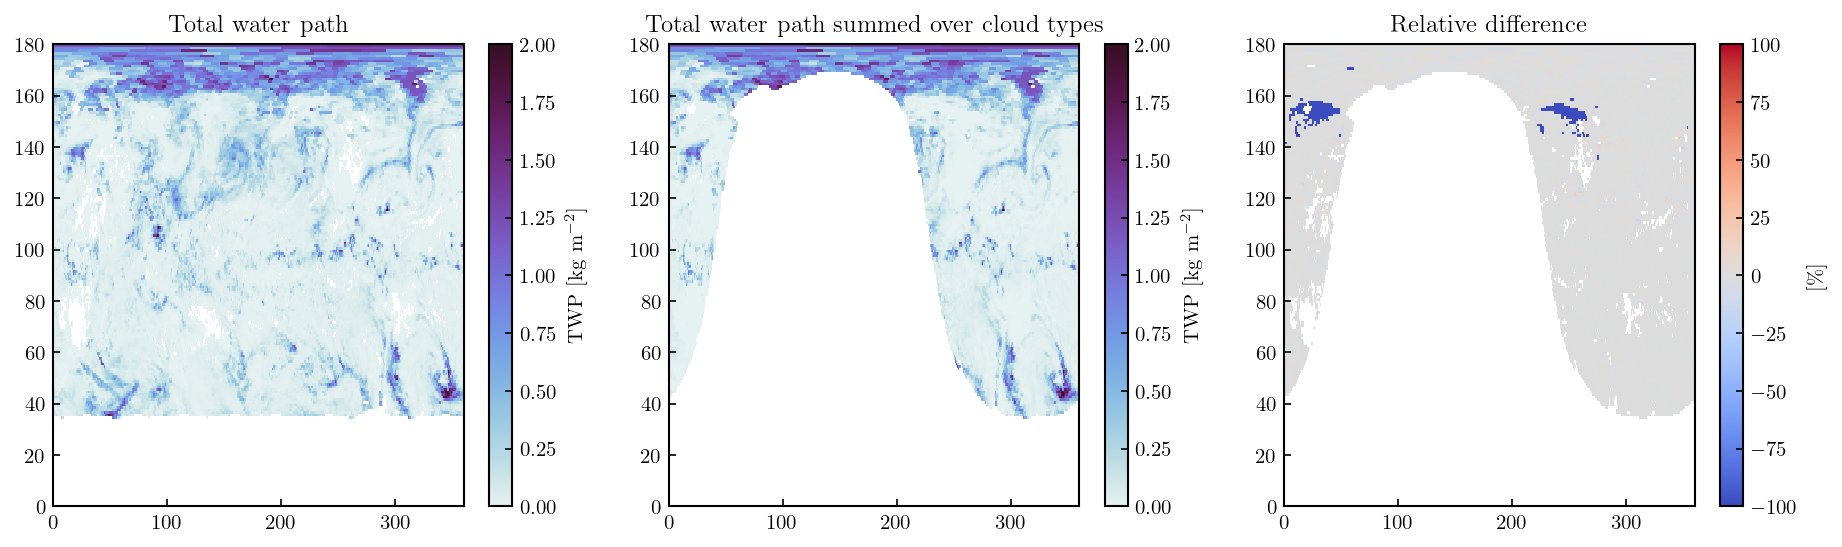

In [15]:
f, axs = plt.subplots(1, 3, figsize=(15, 4))

ax = axs[0]
invalid = ((isccp_data.wp.data[0] < -500) + (isccp_data.wp.data[0] > 28550))
wp = isccp_data.wp.data[0].copy()
wp[invalid] = np.nan

m = ax.pcolormesh(
    wp / 1e3,
    vmin=0,
    vmax=2
)
ax.set_title("Total water path", loc="center")
plt.colorbar(m, label="TWP [kg m$^{-2}$]")

ax = axs[1]
m = ax.pcolormesh(
    calculate_wp(isccp_data),
    vmin=0,
    vmax=2
)
ax.set_title("Total water path summed over cloud types", loc="center")
plt.colorbar(m, label="TWP [kg m$^{-2}$]")

ax = axs[2]
m = ax.pcolormesh(
    (calculate_wp(isccp_data) * 1e3 - wp) / wp * 100,
    vmin=-100,
    vmax=100,
    cmap="coolwarm",
)
ax.set_title("Relative difference", loc="center")
plt.colorbar(m, label="[\%]")


## Aggregate statistics

The code below calculates the spatial distributions of average CA and TIWP as well as the time series of the area-weighted averages.

In [19]:
%rm /scratch/ccic_record/data/processed/isccp_tiwp_ca.nc

rm: cannot remove '/scratch/ccic_record/data/processed/isccp_tiwp_ca.nc': No such file or directory


In [20]:
from tqdm import tqdm
result_path = Path("/scratch/ccic_record/data/processed/isccp_tiwp_ca.nc")

if not result_path.exists():
    times = []
    tiwp_avg = []
    tiwp_avg_masked = []
    ca_avg = []
    ca_avg_masked = []
    tiwp_sum = np.zeros((180, 360))
    tiwp_cts = np.zeros((180, 360))
    ca_sum = np.zeros((180, 360))
    ca_cts = np.zeros((180, 360))
    tiwp_sum_m = np.zeros((12, 180, 360))
    tiwp_cts_m = np.zeros((12, 180, 360))
    ca_sum_m = np.zeros((12, 180, 360))
    ca_cts_m = np.zeros((12, 180, 360))

    lats = np.arange(-90, 90, 1.0) + 0.5
    weights = np.broadcast_to(np.cos(np.deg2rad(lats))[:, np.newaxis], (180, 360))

    for isccp_file in tqdm(isccp_files):
        with xr.open_dataset(isccp_file) as isccp_data:

            times.append(isccp_data.time.data[0])

            month = isccp_data.time.dt.month[0]

            tiwp = calculate_wp(isccp_data, cloud_types=frozen_cloud_mask)
            valid = np.isfinite(tiwp)
            tiwp_sum[valid] += tiwp[valid]
            tiwp_cts += valid.astype("float32")
            tiwp_avg.append((tiwp[valid] * weights[valid]).sum() / weights[valid].sum())
            tiwp_avg_masked.append(
                (tiwp[valid] * (mask * weights)[valid]).sum()
                / (mask * weights)[valid].sum()
            )
            tiwp_sum_m[month - 1, valid] += tiwp[valid]
            tiwp_cts_m[month - 1] += valid.astype("float32")

            ca = isccp_data.cldamt.data[0]
            valid = (-500 < ca) * (ca < 500)
            ca_sum[valid] += ca[valid]
            ca_cts += valid.astype("float32")
            ca_avg.append((ca[valid] * weights[valid]).sum() / weights[valid].sum())
            ca_avg_masked.append(
                (ca[valid] * (mask * weights)[valid]).sum()
                / (mask * weights)[valid].sum()
            )
            ca_sum_m[month - 1, valid] += ca[valid]
            ca_cts_m[month - 1] += valid.astype("float32")

    times = np.array(times)
    tiwp_avg = np.array(tiwp_avg)
    ca_avg = np.array(ca_avg)
    tiwp = tiwp_sum / tiwp_cts
    tiwp = np.roll(tiwp, 180, axis=1)
    ca = ca_sum / ca_cts
    ca = np.roll(ca, 180, axis=1)
    
    tiwp_m = tiwp_sum_m / tiwp_cts_m
    tiwp_m = np.roll(tiwp_m, 180, axis=-1)
    ca_m = ca_sum_m / ca_cts_m
    ca_m = np.roll(ca_m, 180, axis=-1)

    results = xr.Dataset(
        {
            "time": ("time", times),
            "latitude": ("latitude", np.arange(-90, 90, 1.0) + 0.5),
            "longitude": ("longitude", np.arange(-180, 180, 1.0) + 0.5),
            "tiwp_avg": ("time", tiwp_avg),
            "tiwp_avg_masked": ("time", tiwp_avg_masked),
            "ca_avg": ("time", ca_avg),
            "ca_avg_masked": ("time", ca_avg_masked),
            "tiwp": (("latitude", "longitude"), tiwp),
            "ca": (("latitude", "longitude"), ca),
            "tiwp_monthly": (("month", "latitude", "longitude"), tiwp_m),
            "ca_monthly": (("month", "latitude", "longitude"), ca_m),
        }
    )
    results.to_netcdf(result_path)
else:
    results = xr.load_dataset(result_path)

  0%|▊                                                                                                                                                         | 2/408 [00:00<01:45,  3.85it/s]/tmp/ipykernel_3097013/14656253.py:31: RuntimeWarning: invalid value encountered in divide
  wp = (wp_type * cldamt_type / tot_cldamt).sum(0)
  1%|█▌                                                                                                                                                        | 4/408 [00:00<01:15,  5.37it/s]/tmp/ipykernel_3097013/14656253.py:31: RuntimeWarning: invalid value encountered in divide
  wp = (wp_type * cldamt_type / tot_cldamt).sum(0)
  1%|█▉                                                                                                                                                        | 5/408 [00:01<01:10,  5.74it/s]/tmp/ipykernel_3097013/14656253.py:31: RuntimeWarning: invalid value encountered in divide
  wp = (wp_type * cldamt_type / tot_cldamt).sum(0)
 

### Cloud amount

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'vamx'
  result = super().contourf(*args, **kwargs)


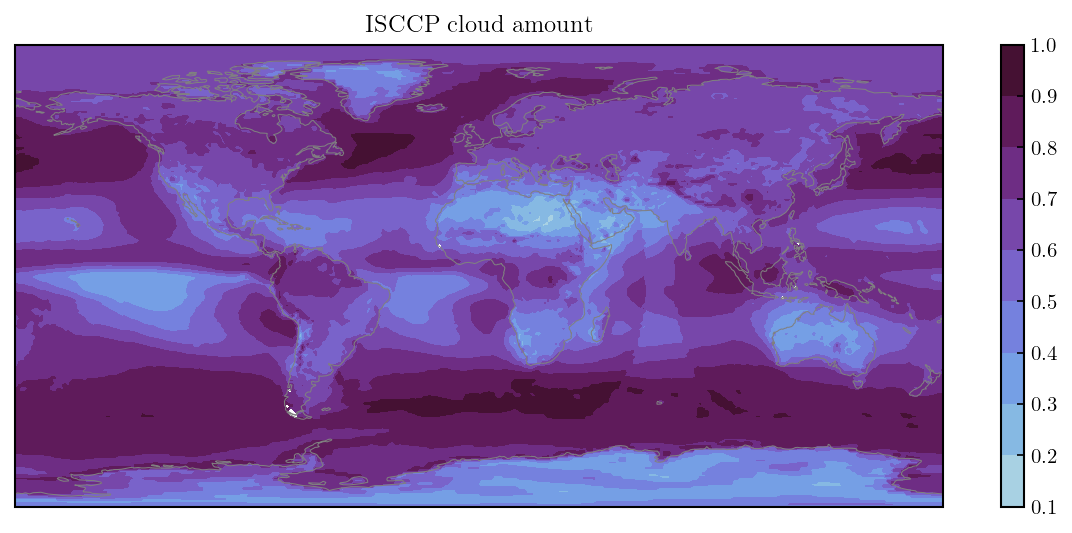

In [21]:
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1, projection=crs)

lons = results.longitude
lats = results.latitude
ca = results.ca.data

m = ax.contourf(lons, lats, ca / 100.0, vmin=0.0, vamx=1.0)
ax.coastlines(color="grey")
ax.set_xlabel("Longitude [$^\circ$ N]")
ax.set_ylabel("Longitude [$^\circ$ N]")
ax.set_title("ISCCP cloud amount", loc="center")

plt.colorbar(m)

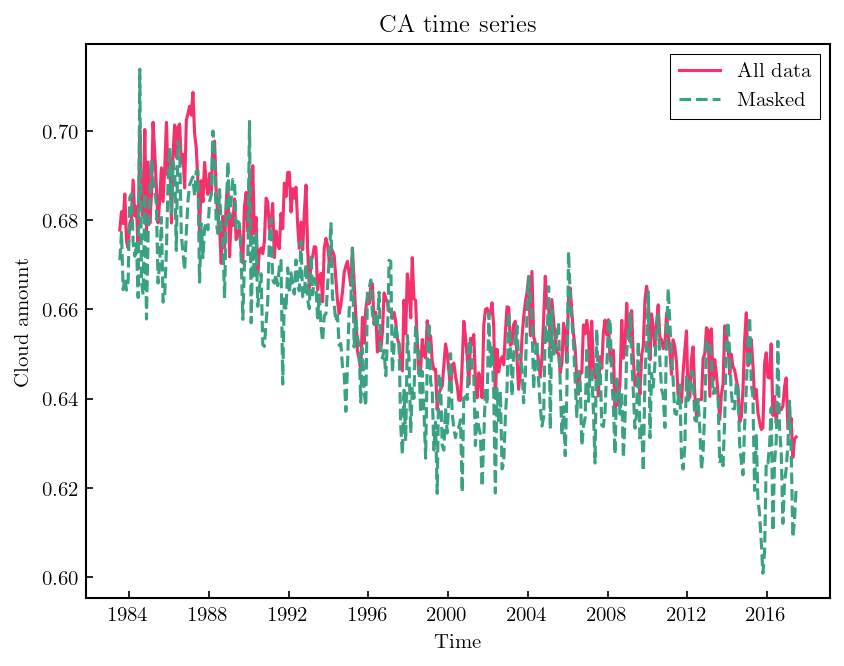

In [22]:
x = results.time
plt.plot(x, results.ca_avg / 100, label="All data")
plt.plot(x, results.ca_avg_masked / 100, ls="--", label="Masked")
plt.xlabel("Time")
plt.ylabel("Cloud amount")
plt.title("CA time series", loc="center")
plt.legend()

## TIWP

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


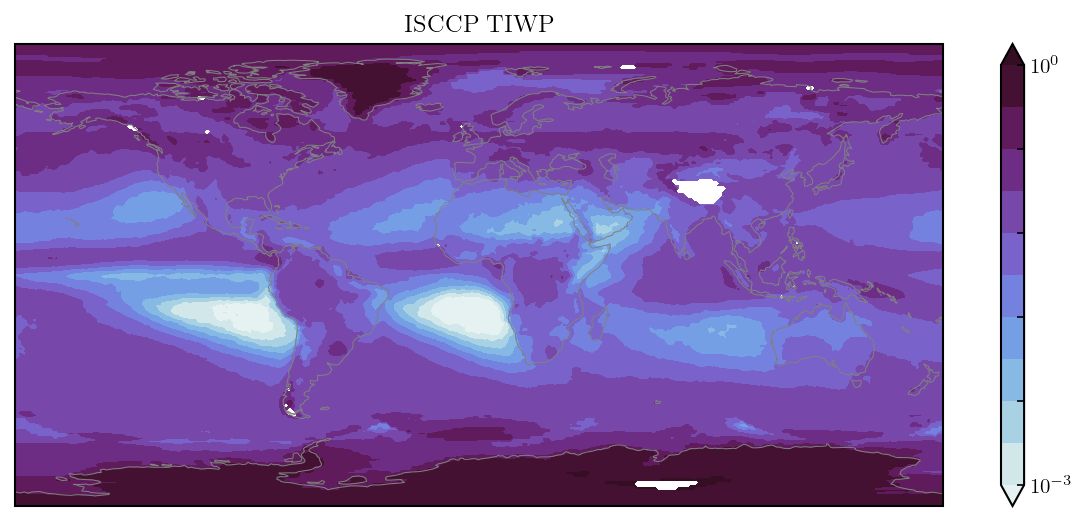

In [24]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1, projection=crs)
norm = LogNorm(1e-3, 1e0)
levels = np.logspace(-3, 0, 11)

lons = results.longitude
lats = results.latitude
tiwp = results.tiwp.data

m = ax.contourf(lons, lats, tiwp, norm=norm, levels=levels, extend="both")
ax.coastlines(color="grey")
ax.set_xlabel("Longitude [$^\circ$ N]")
ax.set_ylabel("Longitude [$^\circ$ N]")
ax.set_title("ISCCP TIWP", loc="center")

plt.colorbar(m)

Text(0.5, 1.0, 'TIWP time series')

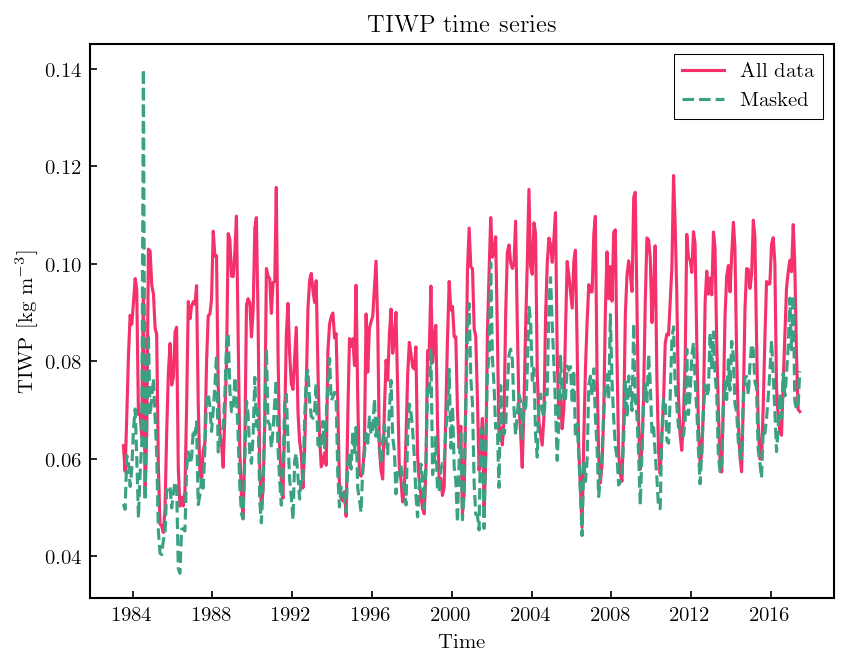

In [25]:
x = results.time
y = results.tiwp_avg
plt.plot(x, results.tiwp_avg, label="All data")
plt.plot(x, results.tiwp_avg_masked, ls="--", label="Masked")
plt.legend()
plt.xlabel("Time")
plt.ylabel("TIWP [kg m$^{-3}$]")
plt.title("TIWP time series", loc="center")
# plt.xlim(np.datetime64("1983-01-01"), np.datetime64("1985-01-01"))

### WP outlier

Since there is a fairly clear outlier in the WP time series, we plot the given month and the following month. The two figure below show the mean water path for the two months. The results for July 1984 obviously contain anomalous WP path results.

In [26]:
isccp_data_84_07 = xr.load_dataset(
    "/scratch/ccic_record/data/isccp/ISCCP-Basic.HGM.v01r00.GLOBAL.1984.07.99.9999.GPC.10KM.CS00.EA1.00.nc"
)
isccp_data_84_08 = xr.load_dataset(
    "/scratch/ccic_record/data/isccp/ISCCP-Basic.HGM.v01r00.GLOBAL.1984.08.99.9999.GPC.10KM.CS00.EA1.00.nc"
)

Text(0.5, 1.0, '1984-08')

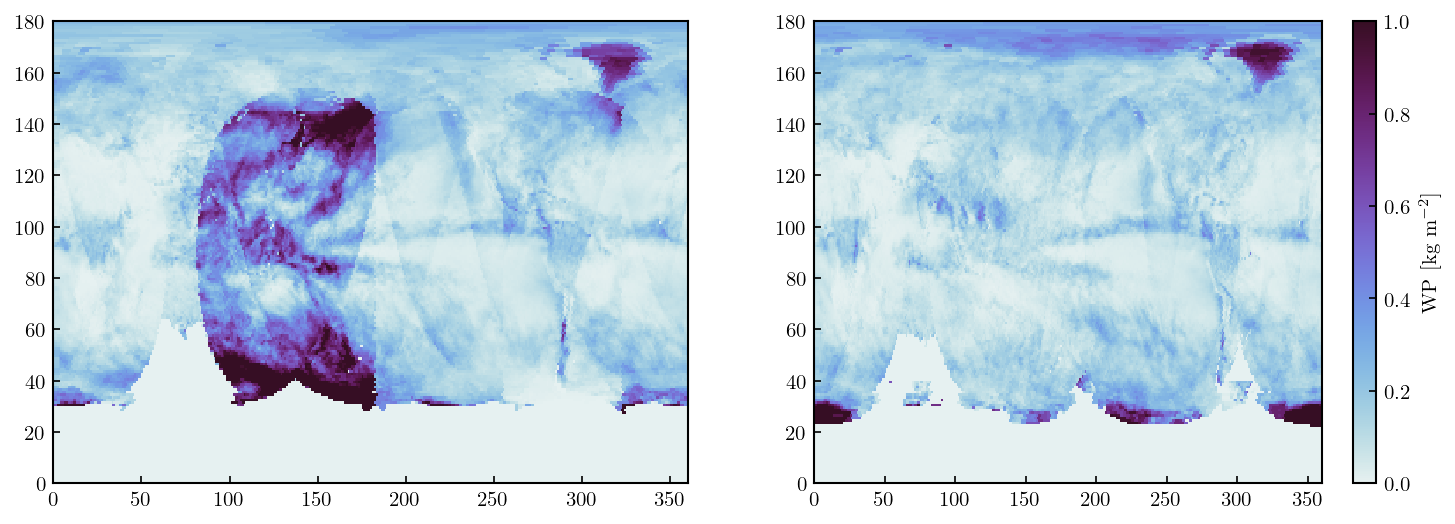

In [27]:
f, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].pcolormesh(isccp_data_84_07.wp.data[0] / 1e3, vmin=0, vmax=1)
ax.set_title("1984-07", loc="center")
m = axs[1].pcolormesh(isccp_data_84_08.wp.data[0] / 1e3, vmin=0, vmax=1)
plt.colorbar(m, label="WP [kg m$^{-2}]$")
ax.set_title("1984-08", loc="center")